<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Train-word-embeddings-model" data-toc-modified-id="Train-word-embeddings-model-1">Train word embeddings model</a></span></li><li><span><a href="#Identify-representative-group-vectors" data-toc-modified-id="Identify-representative-group-vectors-2">Identify representative group vectors</a></span></li><li><span><a href="#Identify-stereotypes-vectors" data-toc-modified-id="Identify-stereotypes-vectors-3">Identify stereotypes vectors</a></span><ul class="toc-item"><li><span><a href="#1.-Most-common-adjectives" data-toc-modified-id="1.-Most-common-adjectives-3.1">1. Most common adjectives</a></span></li><li><span><a href="#2.-Adjectives-that-are-closest-to-each-ethnic-group" data-toc-modified-id="2.-Adjectives-that-are-closest-to-each-ethnic-group-3.2">2. Adjectives that are closest to each ethnic group</a></span></li><li><span><a href="#3.-Adjectives-of-interest" data-toc-modified-id="3.-Adjectives-of-interest-3.3">3. Adjectives of interest</a></span></li><li><span><a href="#4.-Occupations" data-toc-modified-id="4.-Occupations-3.4">4. Occupations</a></span></li></ul></li><li><span><a href="#Calculate-cosine-distance/similarity-between-vectors" data-toc-modified-id="Calculate-cosine-distance/similarity-between-vectors-4">Calculate cosine distance/similarity between vectors</a></span><ul class="toc-item"><li><span><a href="#Identify-closest-words-and-adjectives" data-toc-modified-id="Identify-closest-words-and-adjectives-4.1">Identify closest words and adjectives</a></span></li><li><span><a href="#Compute-stereotypes-score" data-toc-modified-id="Compute-stereotypes-score-4.2">Compute stereotypes score</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt 
import pickle
import seaborn as sns

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.style.use('bmh')

matplotlib.rcParams['text.latex.preamble'] = [
       '\\usepackage{CJK}',
       r'\AtBeginDocument{\begin{CJK}{UTF8}{gbsn}}',
       r'\AtEndDocument{\end{CJK}}',
]

import sys
sys.path.append('../')
from embedding_analysis import *

import jieba
import time
from gensim.models import Word2Vec
%pprint # turn pretty printing off 

<ipython-input-1-b639ac13cd8a>:13: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble'] = [


Pretty printing has been turned OFF


In [2]:
df = pickle.load(open('data/data_时事_clean', 'rb'))
print(df.shape)
df.head()

(53562, 9)


,title,link,date,view,article,len,loc_date,tokens,no_tokens
0,◤头条抢鲜看◢ 2021年7月8日,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,11512,巫统撤回支持 敦促首相下台 慕尤丁宣布依斯迈任副揆 希山升高级部长 ◤新冠又一年◢ 病患满到...,326,None,"[巫统, 撤回, 支持, 敦促, 首相, 下台, 慕尤丁, 宣布, 依斯迈, 任, 副揆, ...",56
1,◤新冠又一年◢ 女子引爆霹雪跨州感染群 验61人 34人确诊,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,28478,国内今日新增1个横跨霹雳和雪兰莪的社区新冠肺炎感染群，首发患者是1名拥有跨州记录的大马公民！...,152,（吉隆坡7日讯）,"[国内, 今日, 新增, 个, 横跨, 霹雳, 和, 雪兰莪, 的, 社区, 新冠, 肺炎,...",73
2,纳兹里：委任依斯迈及希山 能稳定国内政局,https://www.chinapress.com.my/20210707/%e7%ba%...,2021-07-07,16502,巫统硝山国会议员拿督斯里纳兹里指出，委任拿督斯里依斯迈沙比里担任副首相和让拿督斯里希山慕丁担...,233,（吉隆坡7日讯）,"[巫统, 硝山, 国会议员, 拿督斯里, 纳兹里, 指出, 委任, 拿督斯里, 依斯迈沙比里...",97
3,敦马致函议长 要求尽早开国会,https://www.chinapress.com.my/20210707/%e6%95%...,2021-07-07,9832,前首相敦马哈迪说，他已致函向国会下议院议长拿督阿兹哈阿兹占提呈动议，要求尽早召开国会，而不是...,299,（吉隆坡7日讯）,"[前首相, 敦马哈迪, 说, 他, 已, 致函, 向, 国会, 下议院, 议长, 拿督, 阿...",136
4,◤雪州EMCO◢ MITI：雪EMCO区 更多领域可开了,https://www.chinapress.com.my/20210707/%e2%97%...,2021-07-07,183974,国际贸易与工业部宣布，雪州强化行动管制令地区的电气与电子（E&E）行业及其供应链、航空领域（...,279,（吉隆坡7日讯）,"[国际贸易, 与, 工业部, 宣布, 雪州, 强化, 行动, 管制, 令, 地区, 的, 电...",127


# Train word embeddings model

In [3]:
# Train models on a yearly basis and save in a dictionary
models_by_year = {}

for year in df.date.dt.year.unique():
    texts = df.loc[df.date.dt.year==year, 'tokens']
    models_by_year[year] = Word2Vec(sentences=texts, size=300, window=6, 
                                    min_count=5, workers=10, sg=1, hs=0, negative=5, iter=10)

In [4]:
model = models_by_year[2017]

print(model.corpus_count)
print(model.wv.vectors.shape)

7732
(22155, 300)


In [5]:
model.wv.most_similar("马来人", topn=50)

[('排挤', 0.5773759484291077), ('惠顾', 0.5642531514167786), ('公义', 0.5530548691749573), ('微不足道', 0.5419257879257202), ('不择手段', 0.5401684641838074), ('族群', 0.5367504358291626), ('塔利班', 0.5355156660079956), ('少数民族', 0.5202074646949768), ('印度人', 0.5193542242050171), ('忠于', 0.5186895132064819), ('特性', 0.5184544920921326), ('感到恐惧', 0.5178928375244141), ('投给', 0.516737163066864), ('新党', 0.5136004090309143), ('独裁者', 0.5129453539848328), ('叛徒', 0.5125295519828796), ('磨擦', 0.5104191303253174), ('在政治上', 0.5103075504302979), ('平起平坐', 0.509121298789978), ('爪哇人', 0.5076355934143066), ('宪制', 0.5062559843063354), ('中庸之道', 0.504831075668335), ('选票', 0.5044922232627869), ('主义者', 0.5020017623901367), ('反对派', 0.5017076730728149), ('和平共处', 0.5007563829421997), ('始作俑者', 0.49933362007141113), ('巫伊', 0.4971008896827698), ('执政权', 0.49600738286972046), ('当权', 0.4956030249595642), ('反华', 0.4951309859752655), ('嘴巴', 0.4947431981563568), ('圣洁', 0.4945497214794159), ('推倒', 0.49381572008132935), ('马来族', 0.491906940937

In [6]:
model.wv.most_similar('华人', topn=50)

[('华侨', 0.5257167816162109), ('福建人', 0.5129275918006897), ('八大', 0.48886680603027344), ('传统习俗', 0.4884282648563385), ('印度人', 0.4856224060058594), ('张雅诰', 0.4838305413722992), ('社团组织', 0.48233383893966675), ('如厕', 0.4819290339946747), ('海外华人', 0.4802810549736023), ('籍贯', 0.4800894856452942), ('无私奉献', 0.47893673181533813), ('落地生根', 0.4787059426307678), ('大戏', 0.47548532485961914), ('乡亲', 0.4719470739364624), ('汇演', 0.46739116311073303), ('儒商', 0.4659188985824585), ('风味', 0.4639260470867157), ('惠州', 0.46082115173339844), ('接生', 0.46020054817199707), ('姓氏', 0.4601324200630188), ('一中', 0.459955096244812), ('同胞', 0.45416200160980225), ('中华文化', 0.45067644119262695), ('不可磨灭', 0.4486289620399475), ('中华文明', 0.44789236783981323), ('马来人', 0.44662925601005554), ('凝聚', 0.44584181904792786), ('工商', 0.44560736417770386), ('先辈', 0.4445849657058716), ('炎黄子孙', 0.44424548745155334), ('大会堂', 0.44327831268310547), ('艺术表演', 0.44295060634613037), ('春节', 0.44229280948638916), ('全球华人', 0.44212692975997925), ('文

In [7]:
model.wv.most_similar("印度人", topn=50)

[('卡达', 0.7374295592308044), ('道教', 0.6404924392700195), ('锡克教', 0.637911319732666), ('强加在', 0.6290827989578247), ('爪哇人', 0.628768801689148), ('族人', 0.6280932426452637), ('鸡饭', 0.6202324628829956), ('一席之地', 0.6132874488830566), ('很强', 0.6066819429397583), ('特性', 0.601072371006012), ('他族', 0.5999785661697388), ('强项', 0.5986922979354858), ('平凡', 0.5954140424728394), ('默默耕耘', 0.5944069623947144), ('贬低', 0.5908891558647156), ('张雅诰', 0.5901485085487366), ('广东话', 0.5883355736732483), ('社团组织', 0.5873903632164001), ('同胞', 0.5866985321044922), ('文化背景', 0.5866658687591553), ('精进', 0.5861577987670898), ('看在眼里', 0.5839443206787109), ('爱好', 0.5836873054504395), ('同性恋者', 0.5813077688217163), ('排挤', 0.580837070941925), ('LGBT', 0.5807045102119446), ('计较', 0.5806370973587036), ('少数民族', 0.5805144309997559), ('情意', 0.5800421237945557), ('共融', 0.5788365006446838), ('佛教徒', 0.577680230140686), ('人要', 0.5769591331481934), ('籍贯', 0.5754092931747437), ('结交', 0.5746153593063354), ('和睦相处', 0.574236273765564), (

In [8]:
#pickle.dump(models_by_year, open('models/word2vec_by_year_chinese_300d_6w', 'wb'))#

# Identify representative group vectors

- Ethnic group nouns:
    - Malays:  `'马来人', '马来族', '马来民族', '巫裔', '土著'`
    - Indians: `'印度人', '印度族', '印度民族', '印裔', '印度裔'`
    - Chinese: `'华人', '华族', '华裔', '华社', '华侨'`

In [3]:
# Load trained models
models_by_year = pickle.load(open('models/word2vec_by_year_chinese_300d_6w', 'rb'))
models_by_year

{2021: <gensim.models.word2vec.Word2Vec object at 0x000002193D934E80>, 2020: <gensim.models.word2vec.Word2Vec object at 0x000002199F3C58B0>, 2019: <gensim.models.word2vec.Word2Vec object at 0x00000219A2891BE0>, 2018: <gensim.models.word2vec.Word2Vec object at 0x00000219B9A7F520>, 2017: <gensim.models.word2vec.Word2Vec object at 0x00000219BDCC1D60>}

In [4]:
# Examine the usage of group words in each year
malays = ['马来人', '马来族', '马来民族', '巫裔', '土著']
indians = ['印度人', '印度族', '印度民族', '印裔', '印度裔']
chineses = ['华人', '华族', '华裔', '华社', '华侨']

for year in range(2017, 2022):
    print(year)
    print([malay for malay in malays if malay in models_by_year[year].wv.vocab])
    print([chinese for chinese in chineses if chinese in models_by_year[year].wv.vocab])
    print([indian for indian in indians if indian in models_by_year[year].wv.vocab])

2017
['马来人', '马来族', '巫裔', '土著']
['华人', '华族', '华裔', '华社', '华侨']
['印度人', '印裔']
2018
['马来人', '马来族', '马来民族', '巫裔', '土著']
['华人', '华族', '华裔', '华社', '华侨']
['印度人', '印裔']
2019
['马来人', '马来族', '马来民族', '巫裔', '土著']
['华人', '华族', '华裔', '华社', '华侨']
['印度人', '印裔']
2020
['马来人', '巫裔', '土著']
['华人', '华裔', '华社', '华侨']
['印度人', '印裔']
2021
['马来人', '巫裔', '土著']
['华人', '华裔', '华社']
['印裔']


In [5]:
# Count total frequency for each labels in ethnic groups 
df_ind = get_freq_by_year(indians, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_ind.columns = ['noun', 'count']
df_ind['group'] = 'Indians'

df_chi = get_freq_by_year(chineses, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_chi.columns = ['noun', 'count']
df_chi['group'] = 'Chinese'

df_mal = get_freq_by_year(malays, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_mal.columns = ['noun', 'count']
df_mal['group'] = 'Malays'

df_bar = pd.concat([df_ind, df_chi, df_mal])
df_bar.head()

,noun,count,group
0,印裔,1343,Indians
1,印度人,164,Indians
2,印度裔,4,Indians
3,印度族,0,Indians
4,印度民族,0,Indians


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


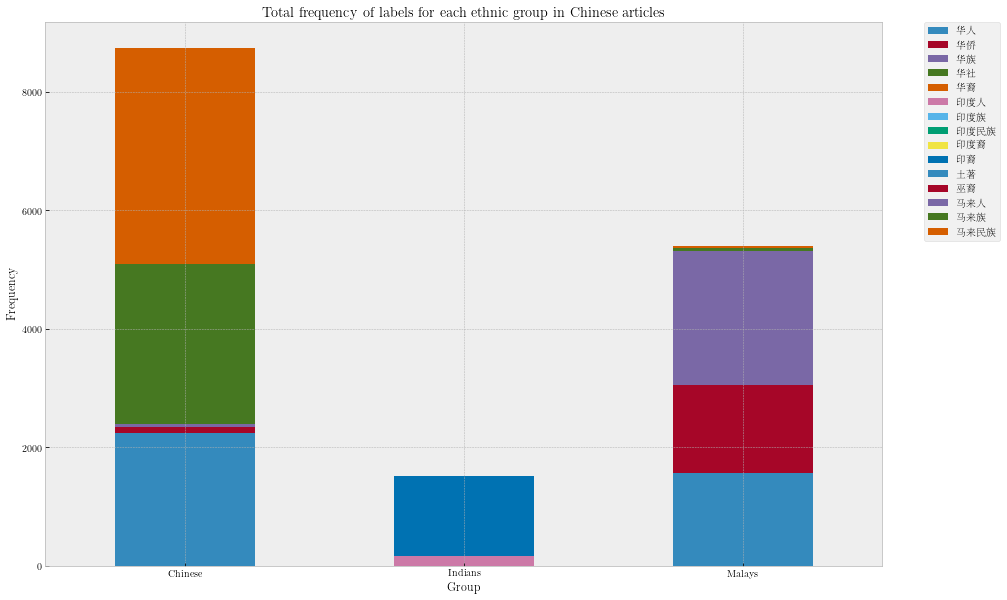

In [6]:
ax = df_bar.pivot(index='group', columns='noun', values='count').plot(kind='bar', stacked=True, figsize=(15, 10))
ax.set_xlabel("Group")
ax.set_ylabel("Frequency")
ax.set_title("Total frequency of labels for each ethnic group in Chinese articles")
plt.xticks(rotation=360)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('figs/chinese_total_freq_labels.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


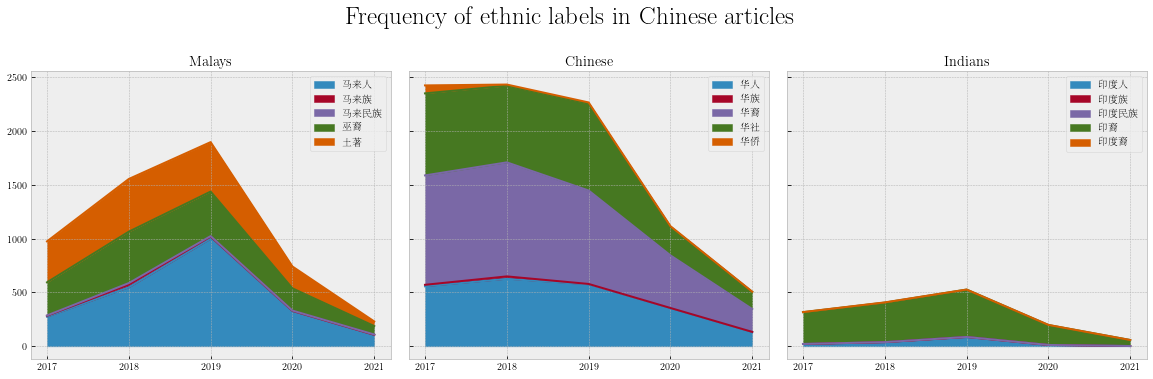

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Frequency of ethnic labels in Chinese articles'
labels = [malays, chineses, indians]
subtitles = ['Malays', 'Chinese', 'Indians']

for idx in range(len(axes)):
    ax = axes[idx]
    get_freq_by_year(labels[idx], df).plot.area(ax=ax)
    ax.locator_params(integer=True)
    ax.set_title(subtitles[idx])

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.8, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/chinese_freq_labels.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


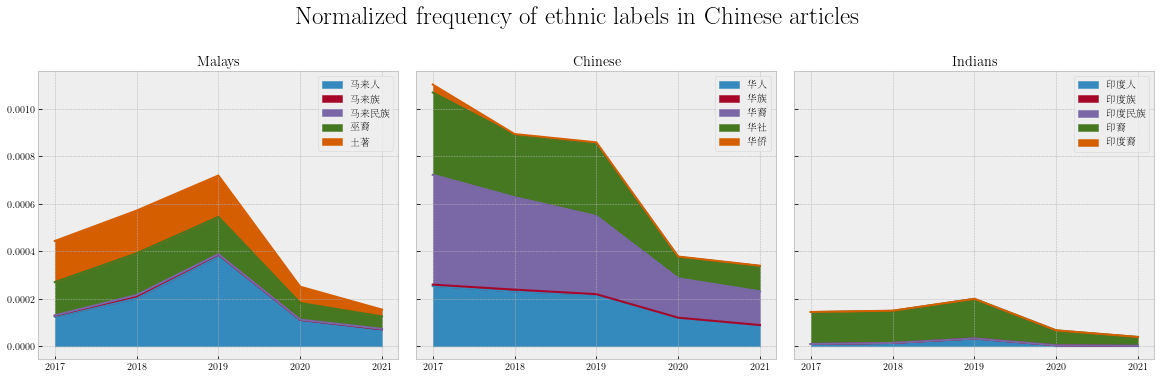

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Normalized frequency of ethnic labels in Chinese articles'
labels = [malays, chineses, indians]
subtitles = ['Malays', 'Chinese', 'Indians']

for idx in range(len(axes)):
    ax = axes[idx]
    get_freq_by_year(labels[idx], df, True).plot.area(ax=ax)
    ax.locator_params(integer=True)
    ax.set_title(subtitles[idx])

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.8, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/chinese_freq_normalized_labels.eps', format='eps')

In [6]:
get_freq_by_year(malays, df).sum(axis=0).sort_values(ascending=False)

马来人     2253
土著      1574
巫裔      1481
马来族       58
马来民族      28
dtype: int64

In [173]:
get_freq_by_year(chineses, df).sum(axis=0).sort_values(ascending=False)

华裔    3640
华社    2702
华人    2243
华侨     104
华族      46
dtype: int64

In [174]:
get_freq_by_year(indians, df).sum(axis=0).sort_values(ascending=False)

印裔      1343
印度人      164
印度裔        4
印度族        0
印度民族       0
dtype: int64

In [7]:
get_freq_by_year(malays, df, True).sum(axis=0).sort_values(ascending=False)

马来人     0.000888
土著      0.000625
巫裔      0.000594
马来族     0.000023
马来民族    0.000011
dtype: float64

# Identify stereotypes vectors

- Types of stereotypes
    1. physical appearances
    2. personal qualities
    3. economic status
    4. occupations
    
 
- Steps of compiling adjectives/nouns for stereotypes (1)-(3)
    1. Select the most common adjectives based on raw frequency 
    2. Select the adjectives that are closest to each ethnic group
    3. Include adjectives of interest

## 1. Most common adjectives

- physical appearance: `'高','老'`
- personal qualities: `'团结', '自由', '不满', '和谐', '年轻', '强', '简单', '强大', '庞大', '友好', '平静', '谨慎', '敏感', '精明', '成熟', '耐心',  '糟糕', '快乐', '佳','虚假', '严谨', '严谨', '复杂', '坚定', '乐观','完美', '美好', '干净', '冷静', '杰出','勇敢', '落后', '笨', '忠诚', '骄傲', '优秀', '肮脏', '愚蠢', '差', '辛苦', '坏', '幸福','愉快', '真诚', '熟练', '友善', '独特'`
- economic status: `'贫穷', '贫困'`

In [25]:
from wordcloud import WordCloud

In [5]:
# Import adjectives identified in pos tagging
adjs = pickle.load(open('data/pos_a', 'rb'))
print(len(adjs))

209813


In [6]:
len(set(adjs)) # number of unique adjectives 

2436

In [178]:
# Select suitable adjectives from top 200 common adjectives 
adjs = pd.Series(adjs)
adjs.value_counts().index[0:200].tolist()

['新', '大', '落实', '重要', '高', '好', '最高', '小', '重新', '成功', '健康', '不同', '严重', '长', '团结', '良好', '有效', '自由', '不满', '尊重', '稳定', '最大', '一般', '清楚', '详情', '和谐', '配套', '低', '最好', '平均', '容易', '最低', '紧急', '年轻', '根本', '少', '不足', '早', '强', '很大', '意外', '连续', '适当', '完整', '先进', '淡', '方便', '简单', '难', '繁荣', '明显', '强大', '全', '庞大', '贫穷', '重大', '友好', '深切', '充足', '短缺', '平静', '谨慎', '平衡', '特殊', '伤害', '尊严', '巨大', '敏感', '旺', '清真', '快', '基建', '惊讶', '合适', '近', '重建', '旧', '平等', '充满', '清洁', '轻易', '不久', '不幸', '强烈', '便利', '空缺', '最', '豪华', '有限', '广泛', '遗憾', '有利', '著名', '便宜', '强迫', '连', '远', '精明', '最多', '具体', '成熟', '耐心', '清理', '不利', '混乱', '古', '黄', '假', '不', '古当', '准确', '糟糕', '久', '快乐', '珍惜', '佳', '不适', '紧密', '重', '老', '深感', '虚假', '艰难', '丰富', '严峻', '很好', '激烈', '严谨', '廉洁', '满', '复杂', '成效', '坚定', '乐观', '紧张', '固定', '辉煌', '美好', '完美', '干净', '不实', '冷静', '舒适', '杰出', '纯粹', '昂贵', '无效', '清单', '连同', '勇敢', '迟', '落后', '热烈', '明福', '充当', '笨', '忠诚', '清白', '明', '骄傲', '诚意', '不安', '不良', '稳固', '轻松', '优秀', '广大', '不错', '显著', '值勤', '极大', '贵', 

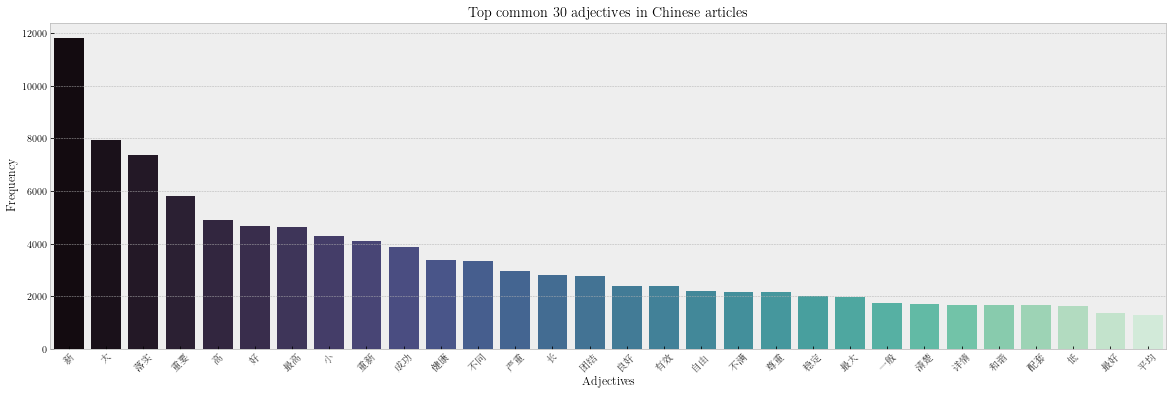

In [8]:
data = pd.Series(adjs).value_counts()[0:30]

fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x=data.index,y=data.values, palette="mako")
ax.set_xlabel("Adjectives")
ax.set_ylabel("Frequency")
ax.set_title("Top common 30 adjectives in Chinese articles")
plt.xticks(rotation=45)

plt.savefig('figs/chinese_top_adjs.eps', format='eps')

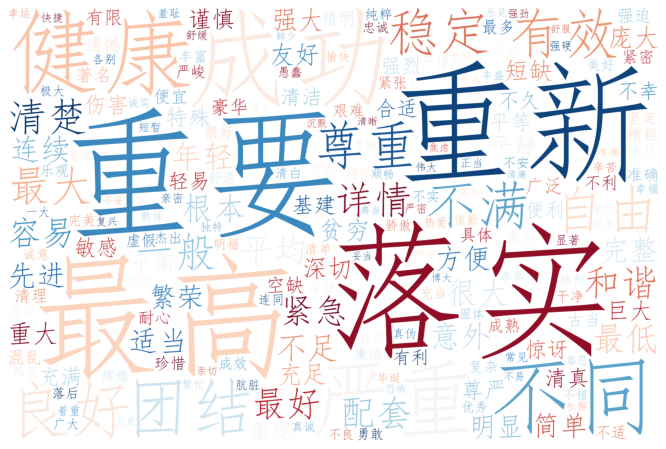

In [45]:
# Specify Chinese font path
font_path = 'C:/WINDOWS/FONTS/SIMFANG.TTF'

# Plot a positive word cloud 
fig, axs = plt.subplots(figsize=(25, 8))
wordcloud = WordCloud(width=1500, height=1000, 
                      prefer_horizontal=1,
                      background_color='white', 
                      collocations=False, 
                      colormap='RdBu', 
                      font_path=font_path,
                      relative_scaling = 0.2,
                      min_word_length = 2,
                      min_font_size=15).generate(' '.join(adjs))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 2. Adjectives that are closest to each ethnic group

In [9]:
adjs = set(adjs)
print(len(adjs))

2436


In [67]:
# Get adjectives close to Malay labels
dict_adj_malay = get_close_adj(malays, models_by_year, adjs, n=200)
dict_adj_malay

{'马来人': {'可耻', '愚昧', '壮大', '偏', '鲜明', '软弱', '慈悲', '贪婪', '团结', '致富', '猛烈', '圣洁', '忠诚', '有感', '平等', '狂热', '无异', '傲慢', '自私', '野蛮', '喜悦', '羞耻', '邪恶', '清廉', '卑鄙', '疏远', '勤劳', '懒惰', '富裕', '薄弱', '私利', '高傲', '脆弱', '典当', '纯洁', '尊严', '单纯', '残暴', '虚伪', '蒙蔽', '齐心', '友善', '封建'}, '马来族': {'壮大', '和谐', '幸福', '鲜明', '慈悲', '强大', '团结', '善良', '贫富', '贫困', '贫穷', '坚固', '狂热', '正信', '温和', '悬殊', '很强', '肤浅', '疏远', '繁荣', '热诚', '薄弱', '强盛', '残酷', '极限', '较弱', '安稳', '残暴', '狭窄', '蒙蔽', '贴切', '狭隘', '封建'}, '马来民族': {'高傲', '纯洁', '封建', '尊严', '鲜明', '精通', '贪婪', '浓厚', '薄弱', '野蛮', '狭隘', '乐趣', '有感'}, '巫裔': {'悠久', '贪婪', '顽皮', '较少', '老', '诙谐', '年迈', '贫穷', '惨', '狂热', '荣显', '普', '羞耻', '最小', '清廉', '优秀', '懒惰', '富裕', '虔诚', '甜蜜', '最短', '年满', '焦虑', '尊严', '忧郁', '谙', '轻伤', '悲痛', '乐趣', '年轻'}, '土著': {'可观', '偏', '华淡', '被裁', '固', '臃肿', '严苛', '贫困', '贫穷', '青', '萧条', '失衡', '悬殊', '净', '有限', '优秀', '赤贫', '薄弱', '私利', '强盛', '典当', '穷', '独', '尊严', '复兴', '清寒', '年轻', '利惠'}}

- physical appearances: `'老', '年迈', '年轻', '臃肿'`
- personal qualities: `'可耻', '愚昧', '软弱', '慈悲', '贪婪', '团结', '忠诚', '狂热', '傲慢', '自私', '野蛮', '喜悦', '羞耻', '邪恶', '清廉', '卑鄙', '勤劳', '懒惰', '薄弱', '高傲', '脆弱', '纯洁', '残暴', '虚伪', '友善', '封建', '幸福', '强大', '善良', '狂热', '温和', '很强', '肤浅', '残酷', 较弱', '安稳', '狭窄', '狭隘', '精通', '贪婪', '乐趣', '顽皮', '诙谐', '惨', '普', '优秀', '虔诚', '甜蜜', '焦虑', '忧郁', '悲痛', '严苛', '强盛'`
- economic status: `'富裕', '贫困', '贫穷', '赤贫', '穷', '清寒'`

In [68]:
# Get adjectives close to Chinese labels
dict_adj_chi = get_close_adj(chineses, models_by_year, adjs, n=200)
dict_adj_chi

{'华人': {'富', '默文', '悠久', '不懈', '精进', '鲜少', '神', '珍贵', '清明', '热闹', '青', '坏', '美好', '很棒', '甜甜', '乐见', '欢乐', '著名', '良心', '很强', '可悲', '热爱', '勤劳', '热诚', '民', '无耻', '雄伟', '富裕', '浓厚', '虔诚', '甜蜜', '强盛', '硬', '执著', '尊严', '友', '根', '友善'}, '华族': {'悠久', '不懈', '鲜明', '平安', '慈悲', '神诞', '善良', '隆重', '顽强', '神', '珍贵', '不单', '忠礼', '正信', '可贵', '很强', '爱好', '灵感', '肤浅', '热爱', '庄严', '热诚', '伟大', '浓厚', '惨痛', '纯洁', '执著'}, '华裔': {'厚望', '清贫', '悠久', '较少', '老', '诙谐', '贫困', '险', '贫寒', '有幸', '普', '很强', '最小', '清廉', '谦逊', '强暴', '优秀', '富裕', '年满', '甜蜜', '最短', '忧郁', '友', '谙', '不小', '狭隘', '清寒', '年轻'}, '华社': {'厚望', '坚定', '尊重', '不懈', '鲜明', '宽容', '华小', '神', '突显', '坏', '美好', '勇敢', '独大', '平等', '正信', '广大', '可贵', '踏实', '诚意', '热爱', '优大', '热诚', '无耻', '诚恳', '频繁', '沉默', '真诚', '强盛', '执著', '穷', '气馁', '艰辛', '不俗', '落力', '蒙蔽', '齐心', '友善', '坦诚'}, '华侨': {'厚望', '悠久', '不懈', '神诞', '丰硕', '善良', '谦虚', '友好合作', '深厚', '幸运', '清明', '谦卑', '友好', '热切', '良心', '雄伟', '清大', '强盛', '最受', '英烈', '有名'}}

- physical appearances: `'老', '年迈', '年轻', '臃肿', '年轻'`
- personal qualities: `'不懈', '精进', '神', '坏', '美好', '很棒', '甜甜', '欢乐', '著名', '很强', '可悲', '勤劳', '无耻', '虔诚', '甜蜜', '强盛', '执著', '友善', '平安', '慈悲', '善良', '隆重', '顽强', '可贵', '肤浅', '庄严', '热诚', '伟大', '纯洁', '诙谐', '普', '清廉', '谦逊', '富裕', '忧郁', '狭隘', '坚定', '宽容', '勇敢', '踏实', '诚意', '诚恳', '沉默', '真诚', '气馁', '不俗', '坦诚', '谦虚', '谦卑', '友好', '有名', '热切'`
- economic status: `'富', '富裕', '清贫', '贫困','贫寒', '清寒', '穷'`

In [69]:
# Get adjectives close to Indians labels
dict_adj_ind = get_close_adj(indians, models_by_year, adjs, n=200)
dict_adj_ind

{'印度人': {'悠久', '鲜明', '精进', '最美', '神', '忠实', '珍贵', '很棒', '狂热', '乐见', '正信', '平凡', '寂寞', '很强', '著名', '爱好', '热爱', '热诚', '懒惰', '雄伟', '富裕', '浓厚', '虔诚', '硬', '穷', '尊严'}, '印度族': set(), '印度民族': set(), '印裔': {'悠久', '鲜少', '强烈', '年迈', '贫困', '贫穷', '贫寒', '广大', '普', '最小', '清廉', '各别', '优秀', '年满', '最短', '团康', '尊严', '轻伤', '清寒', '年轻'}, '印度裔': set()}

- physical appearances: `'最美', '年迈', '年轻'`
- personal qualities: `'精进', '神', '忠实', '很棒', '狂热', '平凡', '寂寞', '很强', '著名','热诚', '懒惰', '虔诚', '清廉', '普','优秀'`
- economic status: `''富裕', '穷', '贫困', '贫穷', '贫寒', '清寒'`

In [70]:
# Get adjectives close to Malay labels (n=500)
dict_adj_ind = get_close_adj(indians, models_by_year, adjs, n=500)
dict_adj_ind

{'印度人': {'最美', '善良', '贫富', '忠实', '狂热', '无异', '广大', '肤浅', '热诚', '民', '高傲', '强盛', '最强', '尊严', '残暴', '友', '厚爱', '愚蠢', '异见', '悠久', '鲜明', '精进', '漂亮', '棒', '有感', '清明', '不爽', '正信', '温和', '很强', '爱好', '执著', '穷', '纯', '偏', '亲密', '老', '贫穷', '忠礼', '著名', '良心', '热爱', '最爱', '懒惰', '雄伟', '炫富', '激怒', '臭', '踏足', '蒙蔽', '富', '不懈', '神', '珍贵', '谦卑', '很棒', '精通', '乐见', '聪明', '平凡', '可贵', '神秘', '寂寞', '白', '相挺', '有苦', '无耻', '恶臭', '富裕', '浓厚', '虔诚', '私利', '硬', '伤健', '最老', '爱丽', '虚伪'}, '印度族': set(), '印度民族': set(), '印裔': {'沙烈', '纯', '清贫', '悠久', '鲜少', '较少', '神', '老', '强烈', '忠实', '优', '惨重', '不安', '不满', '年迈', '有感', '小', '青', '贫穷', '贫困', '淡', '独大', '贫寒', '平等', '狂热', '强迫', '广大', '普', '净', '有功', '最小', '清廉', '热爱', '各别', '强暴', '优秀', '赤贫', '激动', '被困', '年满', '最短', '激怒', '最受', '团康', '杰出', '伤健', '尊严', '爱丽', '不小', '轻伤', '显赫', '清寒', '年轻'}, '印度裔': set()}

- physical appearances: `'最美', '年迈', '年轻', '漂亮', '老', '最老'`
- personal qualities: `'精进', '神', '忠实', '很棒', '狂热', '平凡', '寂寞', '很强', '著名','热诚', '懒惰', '虔诚', '清廉', '普','优秀', '残暴', '愚蠢', '棒', '温和', '执著', '可贵', '神秘', '无耻', '恶臭', '虔诚', '虚伪', '神', '忠实', '优', '不安', '不满', '有功', '杰出'`
- economic status: `'富裕', '穷', '贫困', '贫穷', '贫寒', '清寒', '清贫','赤贫', '显赫'`

## 3. Adjectives of interest

- physical appearances: `'瘦小', '瘦弱', '矮小', '苗条', '健壮', '强壮', '整洁'`
- personal qualities: `'极端', '不择手段', '种族主义者', '微不足道', '酷', '中庸', '个人主义', '高尚', '短视', '弱势', '保守主义', '世俗', '前瞻性', '爱国主义', '开明', '沙文主义', '二等'`
- economic status: `'拮据','宽裕', '富足', '穷困潦倒', '富足', '富甲一方'`

## 4. Occupations 

- Steps of compiling occupations
    1. Occupations closest to each ethnic group
         - `'政客', '家庭主妇', '义工', '联络官', '小学教师' '传教士', '艺术家', '经销商', '园主', '教育家'`
    2. Occupations from Garg et al. (2018) 
        - `'清道夫', '清洁人员', '统计学家', '助产士', '法警', '拍卖师', '摄影师', '地质学家', '鞋匠', '运动员', '收银员', '舞者', '管家', '会计师', '物理学家', '园丁', '牙医', '织布工', '铁匠', '心理学家', '主管', '数学家', '测量员', '裁缝', '设计师', '经济学家', '机械师', '工人', '邮政局长', '经纪人', '化学家', '图书管理员', '服务员', '文员', '音乐家', '搬运工', '科学家', '木匠', '水手', '讲师', '警长', '飞行员', '飞机师', '检查员', '泥瓦匠', '面包师', '管理员', '建筑师', '收藏家', '操作员', '外科医生', '司机', '画家', '售票员', '护士', '厨师', '工程师', '退休人士', '销售员', '律师', '神职人员', '医生', '农民', '经理', '警卫', '艺术家', '官员', '警察', '医生', '教授', '学生', '法官', '老师', '作者', '作家', '秘书', '士兵', '军人'`

In [16]:
appearances = ['瘦小', '瘦弱', '矮小', '苗条', '健壮', '强壮', '整洁','最美', '年迈', '年轻', 
               '漂亮', '老', '最老', '老', '年迈', '年轻', '臃肿', '年轻','老', '年迈', '年轻', 
               '臃肿', '高','老']

qualities = ['极端', '不择手段', '种族主义者', '微不足道', '酷', '中庸', '个人主义', '高尚', '短视', '弱势', 
             '保守主义', '世俗', '前瞻性', '爱国主义', '开明', '沙文主义', '二等', '精进', '神', '忠实', '很棒', 
             '狂热', '平凡', '寂寞', '很强', '著名','热诚', '懒惰', '虔诚', '清廉', '普','优秀', '残暴', '愚蠢', 
             '棒', '温和', '执著', '可贵', '神秘', '无耻', '恶臭', '虔诚', '虚伪', '神', '忠实', '优', '不安', '不满', '有功', '杰出',
             '不懈', '精进', '神', '坏', '美好', '很棒', '甜甜', '欢乐', '著名', '很强', '可悲', '勤劳', '无耻', '虔诚', '甜蜜', '强盛', 
             '执著', '友善', '平安', '慈悲', '善良', '隆重', '顽强', '可贵', '肤浅', '庄严', '热诚', '伟大', '纯洁', '诙谐', '普', 
             '清廉', '谦逊', '富裕', '忧郁', '狭隘', '坚定', '宽容', '勇敢', '踏实', '诚意', '诚恳', '沉默', '真诚', '气馁', '不俗', 
             '坦诚', '谦虚', '谦卑', '友好', '有名', '热切', '可耻', '愚昧', '软弱', '慈悲', '贪婪', '团结', '忠诚', '狂热', '傲慢', 
             '自私', '野蛮', '喜悦', '羞耻', '邪恶', '清廉', '卑鄙', '勤劳', '懒惰', '薄弱', '高傲', '脆弱', '纯洁', '残暴', '虚伪', 
             '友善', '封建', '幸福', '强大', '善良', '狂热', '温和', '很强', '肤浅', '残酷', '较弱', '安稳', '狭窄', '狭隘', '精通', 
             '贪婪', '乐趣', '顽皮', '诙谐', '惨', '普', '优秀', '虔诚', '甜蜜', '焦虑', '忧郁', '悲痛', '严苛', '强盛', '团结', 
             '自由', '不满', '和谐', '年轻', '强', '简单', '强大', '庞大', '友好', '平静', '谨慎', '敏感', '精明', '成熟', '耐心',  
             '糟糕', '快乐', '佳','虚假', '严谨', '严谨', '复杂', '坚定', '乐观','完美', '美好', '干净', '冷静', '杰出','勇敢', '落后', 
             '笨', '忠诚', '骄傲', '优秀', '肮脏', '愚蠢', '差', '辛苦', '坏', '幸福','愉快', '真诚', '熟练', '友善', '独特']

economic = ['贫穷', '贫困', '富裕', '贫困', '贫穷', '赤贫', '穷', '清寒', '富', '富裕', '清贫', '贫困','贫寒', '清寒', '穷',
            '富裕', '穷', '贫困', '贫穷', '贫寒', '清寒', '清贫','赤贫', '显赫', '拮据','宽裕', '富足', '穷困潦倒', '富足', '富甲一方']

occupations = ['政客', '家庭主妇', '义工', '联络官', '小学教师' '传教士', '艺术家', '经销商', '园主', '教育家', '清道夫', '清洁人员', 
               '统计学家', '助产士', '法警', '拍卖师', '摄影师', '地质学家', '鞋匠', '运动员', '收银员', '舞者', '管家', '会计师', '物理学家', 
               '园丁', '牙医', '织布工', '铁匠', '心理学家', '主管', '数学家', '测量员', '裁缝', '设计师', '经济学家', '机械师', '工人', '邮政局长', 
               '经纪人', '化学家', '图书管理员', '服务员', '文员', '音乐家', '搬运工', '科学家', '木匠', '水手', '讲师', '警长', '飞行员', '飞机师', 
               '检查员', '泥瓦匠', '面包师', '管理员', '建筑师', '收藏家', '操作员', '外科医生', '司机', '画家', '售票员', '护士', '厨师', '工程师', 
               '退休人士', '销售员', '律师', '神职人员', '医生', '农民', '经理', '警卫', '艺术家', '官员', '警察', '医生', '教授', '学生', '法官', 
               '老师', '作者', '作家', '秘书', '士兵', '军人' ]

print(len(set(appearances)))
print(len(set(qualities)))
print(len(set(economic)))
print(len(set(occupations)))

15
148
15
85


In [17]:
# Filter adjectives and nouns by occurrence 
appear_filtered = filter_word_by_occurrence(set(appearances), models_by_year)
print(len(appear_filtered))
print(appear_filtered)

qualities_filtered = filter_word_by_occurrence(set(qualities), models_by_year)
print(len(qualities_filtered))
print(qualities_filtered)

economic_filtered = filter_word_by_occurrence(set(economic), models_by_year)
print(len(economic_filtered))
print(economic_filtered)

occu_filtered = filter_word_by_occurrence(set(occupations), models_by_year)
print(len(occu_filtered))
print(occu_filtered)

4
['年迈', '高', '年轻', '老']
81
['坦诚', '冷静', '甜蜜', '自私', '薄弱', '神', '不懈', '耐心', '坚定', '成熟', '悲痛', '快乐', '谨慎', '沉默', '完美', '著名', '差', '富裕', '中庸', '乐观', '软弱', '愉快', '不满', '极端', '落后', '伟大', '狭隘', '平静', '团结', '诚意', '强大', '宽容', '强', '自由', '可耻', '独特', '干净', '友好', '贪婪', '弱势', '邪恶', '平安', '简单', '精通', '严谨', '友善', '骄傲', '佳', '喜悦', '虚假', '欢乐', '复杂', '糟糕', '肮脏', '羞耻', '不安', '坏', '美好', '幸福', '敏感', '沙文主义', '焦虑', '愚蠢', '勤劳', '忠诚', '年轻', '优秀', '开明', '脆弱', '残酷', '勇敢', '可悲', '真诚', '熟练', '精明', '神秘', '清廉', '辛苦', '和谐', '庞大', '杰出']
3
['贫困', '富裕', '贫穷']
33
['军人', '老师', '讲师', '运动员', '政客', '管理员', '工程师', '秘书', '护士', '工人', '官员', '医生', '摄影师', '经济学家', '义工', '园主', '艺术家', '作者', '会计师', '农民', '科学家', '警长', '家庭主妇', '警察', '经理', '教授', '牙医', '法官', '设计师', '主管', '司机', '学生', '律师']


# Calculate cosine distance/similarity between vectors

- Criteria for selecting ethnic labels
    - Frequency/Prevalence of the noun
    - Occurrence in every year
    - Similarity with the word '种族'
    - Comparability with other ethnic nouns eg. `华侨` and `土著`

In [11]:
# Filter out labels that do not appear every year
malays_filtered = filter_word_by_occurrence(malays, models_by_year)
print(malays_filtered)

chinese_filtered = filter_word_by_occurrence(chineses, models_by_year)
print(chinese_filtered)

indians_filtered = filter_word_by_occurrence(indians, models_by_year)
print(indians_filtered)

['马来人', '巫裔', '土著']
['华人', '华裔', '华社']
['印裔']


## Identify closest words and adjectives 

In [28]:
for malay in malays_filtered:
    print(malay)
    print(get_close_word(malay, models_by_year, 10).to_markdown())

马来人
|      | 0        | 1      | 2        | 3        | 4        | 5    | 6        | 7        | 8        | 9        |
|-----:|:---------|:-------|:---------|:---------|:---------|:-----|:---------|:---------|:---------|:---------|
| 2017 | 排挤     | 惠顾   | 公义     | 微不足道 | 不择手段 | 族群 | 塔利班   | 少数民族 | 印度人   | 忠于     |
| 2018 | 种族主义 | 至上   | 伊班人   | 叛徒     | JMM      | 世俗 | 印度人   | 马来族   | 特权     | 共产主义 |
| 2019 | 尊严     | 大团结 | 巫裔     | 印度人   | 马来族   | 剿灭 | 走狗     | 对非     | 土著     | 他族     |
| 2020 | 傀儡     | 讨好   | 沙文主义 | 妖魔化   | 讨厌     | 摧毁 | 自由主义 | 共产主义 | 霸权     | 独裁者   |
| 2021 | 对手     | 捞取   | 大团结   | 个人利益 | 中庸     | 否定 | 政客     | 前途     | 混为一谈 | 色彩     |
巫裔
|      | 0      | 1    | 2      | 3      | 4    | 5      | 6      | 7        | 8      | 9      |
|-----:|:-------|:-----|:-------|:-------|:-----|:-------|:-------|:---------|:-------|:-------|
| 2017 | 华裔   | 印裔 | 裔     | 谋生   | 年介 | 同胞   | 年长者 | 一群     | 余岁   | 巴仙   |
| 2018 | 华裔   | 印裔 | 同胞   | 老兵   | 土着 | 未婚   | 生报   | 居多    

In [36]:
get_close_word('巫裔', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,华裔,印裔,裔,谋生,年介,同胞,年长者,一群,余岁,巴仙,避而不谈,站台,支持率,老妇,已婚,金神銮,同窗,辍学生,一家之主,小镇
2018,华裔,印裔,同胞,老兵,土着,未婚,生报,居多,童婚案,中年,与非,对非,迎娶,男女,生育率,年长者,马来人,自居,游离,十多年
2019,印裔,华裔,马来人,占多数,华巫,马来族,占上风,少数民族,传道,对非,沙文主义,更多非,名非,票仓,回流,排挤,大票,华族,学额固,马桶
2020,对友族,华裔,印裔,伊班,不谙,友族,同化,女友,女生,小生,女孩,少年,占多数,名女,一面倒,弟妹,爷爷,年仅,子弟,女中
2021,华裔,印裔,居多,女生,参政,选票,男生,魔鬼,清廉,马来人,一把,多岁,同胞,政治家,支持率,知名人士,唾弃,重划,亲,范


In [12]:
get_close_adj_by_year('巫裔', models_by_year, adjs, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,最短,粗俗,有名,年迈,真名,疏远,年满,薄弱,疯狂,最小,出奇,虚弱,平凡,可悲,贫困,正信,善良,笨,惊动,不小
2018,团康,薄弱,年迈,有感,诙谐,虔诚,有名,清寒,悲哀,自满,出奇,偏,贫穷,封建,高低,悬殊,友,爱丽,厚望,贫困
2019,狂热,悬殊,懒惰,忧郁,乐趣,狭隘,失衡,很强,偏,激怒,尊严,谦逊,激动,年满,壮大,被困,无耻,鲜明,精通,最小
2020,顽皮,抑郁,残酷,普,轻伤,猖狂,富裕,不均,谙,悠久,最小,致富,较少,华淡,微弱,华小,蒙蔽,优,谦虚,赤贫
2021,清廉,最小,甜蜜,优秀,年轻,荣显,脆弱,勤劳,漂亮,尊严,不小,热爱,典当,残忍,坦诚,红,私利,微薄,老,愚昧


In [30]:
for chinese in chinese_filtered:
    print(chinese)
    print(get_close_word(chinese, models_by_year, 10).to_markdown())

华人
|      | 0      | 1        | 2        | 3        | 4      | 5      | 6        | 7    | 8        | 9      |
|-----:|:-------|:---------|:---------|:---------|:-------|:-------|:---------|:-----|:---------|:-------|
| 2017 | 华侨   | 福建人   | 八大     | 传统习俗 | 印度人 | 张雅诰 | 社团组织 | 如厕 | 海外华人 | 籍贯   |
| 2018 | 印度人 | 伊班人   | 先贤     | 籍贯     | 同胞   | 大团结 | 华裔     | 姓氏 | 大会堂   | MCTA   |
| 2019 | 印度人 | 卡达     | 文化节   | 大会堂   | 旧客   | 祖籍   | 马来人   | 姓氏 | 福建人   | 福建   |
| 2020 | 印度人 | 宗长     | 传统节日 | 陈午峤   | 华侨   | 悠久   | 马来人   | 小镇 | 血统     | 异教徒 |
| 2021 | 博物馆 | 沙文主义 | 林氏     | 道教     | 会馆   | 厨业   | 姑苏     | 温馨 | 各族人民 | 金钻   |
华裔
|      | 0    | 1    | 2    | 3        | 4    | 5    | 6      | 7      | 8        | 9    |
|-----:|:-----|:-----|:-----|:---------|:-----|:-----|:-------|:-------|:---------|:-----|
| 2017 | 巫裔 | 印裔 | 子弟 | 同胞     | 谋生 | 友族 | 佛教徒 | 密集区 | 非土著   | 华人 |
| 2018 | 印裔 | 巫裔 | 同胞 | 华人     | 生报 | 子弟 | 华印   | 入伍   | 小商     | 华社 |
| 2019 | 印裔 | 巫裔 | 子弟 | 居多     | 同胞 | 获约 | 大票   | 华

In [37]:
get_close_word('华裔', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,巫裔,印裔,子弟,同胞,谋生,友族,佛教徒,密集区,非土著,华人,年介,向往,喝彩,教育家,平均年龄,人口比例,德高望重,冷感,不谙,改观
2018,印裔,巫裔,同胞,华人,生报,子弟,华印,入伍,小商,华社,友族,先贤,男女,当兵,老兵,一夫多妻制,关键性,面孔,生育率,团康
2019,印裔,巫裔,子弟,居多,同胞,获约,大票,华巫,名非,票仓,占多数,回流,清寒,祖籍,居次,屈指可数,矮化,大力支持,少数民族,更多非
2020,印裔,巫裔,子弟,伊班,同胞,不谙,华人,小生,一辈,同化,姓氏,悠久,裔,名女,女友,卡达,年轻,苏来曼,中学教师,爷爷
2021,巫裔,印裔,同胞,知名人士,子弟,行善,盛会,先贤,恭喜发财,居多,选票,佛教,前辈,甜蜜,男生,华,女生,华社,客家,友族


In [13]:
get_close_adj_by_year('华裔', models_by_year, adjs, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,清贫,最短,贫困,冷淡,年轻,优秀,平凡,疏远,不懈,热诚,谙,很强,较难,显赫,落后,纯,艰辛,浓厚,正信,不小
2018,团康,清寒,友,年迈,华小,广大,年轻,寂寞,有感,不俗,诙谐,清大,骄傲,厚望,谙,优越,不均,厚爱,虔诚,微薄
2019,清寒,最小,悬殊,不小,忧郁,沙大,优异,年满,险,鲜明,独大,可敏,谦逊,谙,年轻,乐趣,不单,精通,硬,深
2020,悠久,年轻,普,贫寒,忠实,较少,优秀,顽皮,贫穷,高傲,轻伤,独,臃肿,华小,蒙蔽,最小,纯,优异,佳,优
2021,甜蜜,清廉,华小,热爱,勤劳,最小,优秀,香,有幸,强烈,频繁,默文,强暴,老,平安,甜甜,贫困,淡,杰出,坦诚


In [34]:
for indian in indians_filtered:
    print(indian)
    print(get_close_word(indian, models_by_year, 10).to_markdown())

印裔
|      | 0    | 1    | 2      | 3      | 4        | 5        | 6    | 7      | 8      | 9      |
|-----:|:-----|:-----|:-------|:-------|:---------|:---------|:-----|:-------|:-------|:-------|
| 2017 | 华裔 | 巫裔 | 年介   | 同胞   | 裔       | 卡达     | 社群 | 印度人 | 土著   | 阿末法 |
| 2018 | 华裔 | 巫裔 | 伊班人 | 同胞   | 土着     | 卡达     | 县市 | 男女   | 未婚   | 中年   |
| 2019 | 华裔 | 巫裔 | 华巫   | 客人   | 社群     | 卡达     | 获约 | 印度人 | 忠诚度 | 吉灵人 |
| 2020 | 华裔 | 伊班 | 巫裔   | 印度人 | 新加坡籍 | 同化     | 裔   | 小生   | 卡达   | 土著   |
| 2021 | 巫裔 | 华裔 | 土著   | 楷模   | 多岁     | 阿鲁姆甘 | 佛教 | 喜爱   | 育有   | 男生   |


In [9]:
print(get_close_word('印度人', models_by_year, 10).to_markdown())

|      | 0      | 1    | 2      | 3      | 4        | 5        | 6    | 7        | 8        | 9      |
|-----:|:-------|:-----|:-------|:-------|:---------|:---------|:-----|:---------|:---------|:-------|
| 2017 | 卡达   | 道教 | 锡克教 | 强加在 | 爪哇人   | 族人     | 鸡饭 | 一席之地 | 很强     | 特性   |
| 2018 | 伊班人 | 反华 | 自居   | 外来者 | 台湾人   | 建国初期 | 上万 | 坏话     | 卡达     | 客家人 |
| 2019 | 旧客   | 华人 | 新客   | 卡达   | 少数民族 | 沙文主义 | 客人 | 风俗     | 对非     | 马来人 |
| 2020 | 悠久   | 卡达 | 小镇   | 魅力   | 伊班     | 敌视     | 锡克 | 同化     | 传统节日 | 习俗   |


In [35]:
get_close_word('印裔', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,华裔,巫裔,年介,同胞,裔,卡达,社群,印度人,土著,阿末法,同窗,娘,族人,遭霸,同性恋者,离家出走,巡长,老妇,最短,各族
2018,华裔,巫裔,伊班人,同胞,土着,卡达,县市,男女,未婚,中年,慕鲁根,族群,生育率,社群,成年,童婚案,印度人,迎娶,老兵,居多
2019,华裔,巫裔,华巫,客人,社群,卡达,获约,印度人,忠诚度,吉灵人,当众,教徒,大票,更多非,恫言,碑,仓,旧客,兴都,同胞
2020,华裔,伊班,巫裔,印度人,新加坡籍,同化,裔,小生,卡达,土著,绝大部分,锡克,子弟,越南籍,不谙,结婚年龄,印,华校,改信,年届
2021,巫裔,华裔,土著,楷模,多岁,阿鲁姆甘,佛教,喜爱,育有,男生,最小,秘诀,头衔,妇孺,女,居多,客家,族,传教士,帕劳


In [14]:
get_close_adj_by_year('印裔', models_by_year, adjs, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,最短,疏远,显赫,年满,贫穷,贫困,纯,清贫,淡,青,热诚,惨,贫富,正信,最小,激动,赤贫,繁华,冷淡,残暴
2018,团康,有感,年迈,肥胖,各别,清寒,贫困,伤健,清贫,不均,悲痛,贫穷,爱丽,有功,烦恼,笨,薄弱,粗糙,厚望,最小
2019,独大,神,悬殊,激怒,狂热,贫穷,鲜明,清寒,忠诚,鲜少,无耻,冷淡,固,淡,野蛮,广受,有功,自爆,不安,激动
2020,普,轻伤,较少,悠久,抑郁,赤贫,贫寒,有功,纯,重伤,华淡,优,最小,致富,高傲,贫穷,残暴,青,淡,不达
2021,最小,青,杰出,甜蜜,惨重,清廉,微薄,荣显,残忍,强暴,优秀,强烈,不小,轻伤,典当,尊严,私利,漂亮,妥当,玲珑


## Compute stereotypes score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


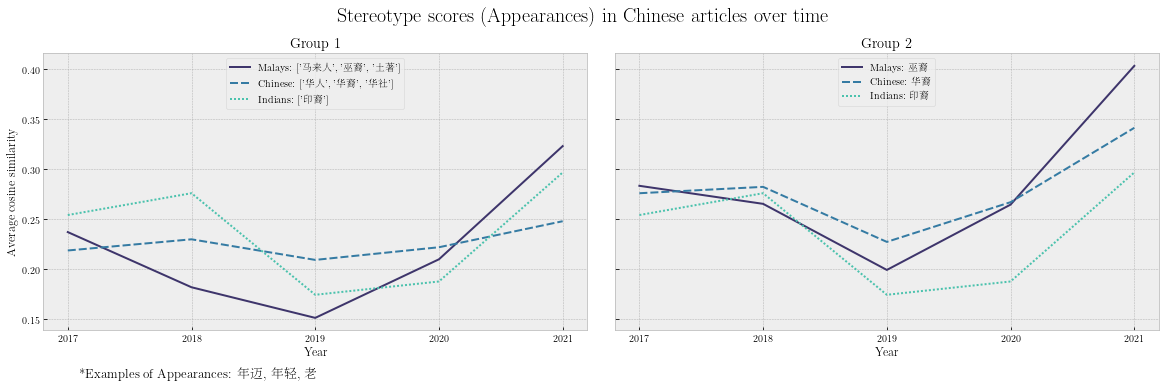

In [18]:
# Appearance stereotypes
appear_filtered = ['年迈', '年轻', '老']

# Group 1 - ethnic labels appearing in every year
dist = []

for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, appear_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, appear_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, appear_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])

df_dist_1 = pd.DataFrame(dist, index = models_by_year.keys(),
                       columns =  ['Malays: {}'.format(malays_filtered), 
                                   'Chinese: {}'.format(chinese_filtered), 
                                   'Indians: {}'.format(indians_filtered)])
    
# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(['巫裔'], appear_filtered, embeddings)
    dist_chi = get_average_sim(['华裔'], appear_filtered, embeddings)
    dist_ind = get_average_sim(['印裔'], appear_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])

df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format('巫裔'), 
                                    'Chinese: {}'.format('华裔'), 
                                    'Indians: {}'.format('印裔')])

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Appearances) in Chinese articles over time'
annotation = '*Examples of Appearances: ' + ', '.join(appear_filtered)

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="mako")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/chi_stereo_appear.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


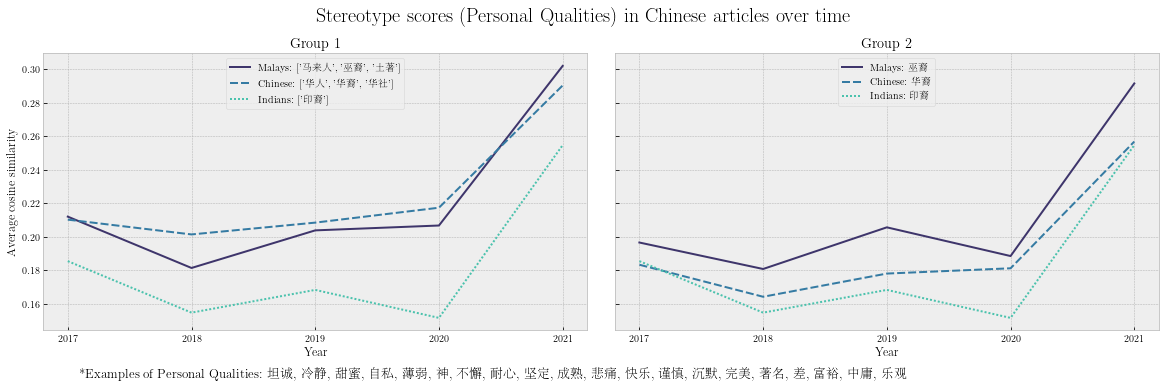

In [19]:
# Personal Quality Stereotypes
# Group 1 - ethnic labels appearing in every year
dist = []

for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, qualities_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, qualities_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, qualities_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(['巫裔'], qualities_filtered, embeddings)
    dist_chi = get_average_sim(['华裔'], qualities_filtered, embeddings)
    dist_ind = get_average_sim(['印裔'], qualities_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format('巫裔'), 
                                    'Chinese: {}'.format('华裔'), 
                                    'Indians: {}'.format('印裔')])


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Personal Qualities) in Chinese articles over time'
annotation = '*Examples of Personal Qualities: ' + ', '.join(qualities_filtered[:20]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="mako")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/chi_stereo_pq.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


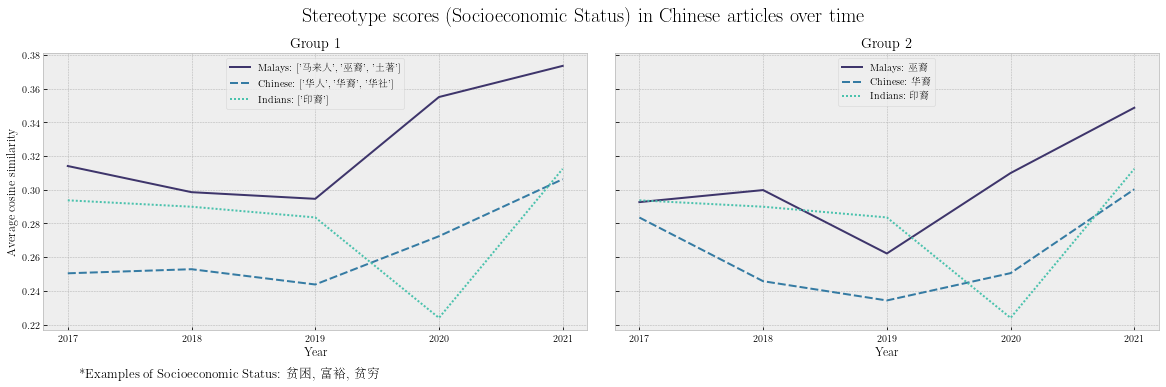

In [22]:
# Socioeconomic status stereotypes
# Group 1 - ethnic labels appearing in every year
dist = []

for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, economic_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, economic_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, economic_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(['巫裔'], economic_filtered, embeddings)
    dist_chi = get_average_sim(['华裔'], economic_filtered, embeddings)
    dist_ind = get_average_sim(['印裔'], economic_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format('巫裔'), 
                                    'Chinese: {}'.format('华裔'), 
                                    'Indians: {}'.format('印裔')])


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Socioeconomic Status) in Chinese articles over time'
annotation = '*Examples of Socioeconomic Status: ' + ', '.join(economic_filtered[:20]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="mako")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/chi_stereo_ss.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


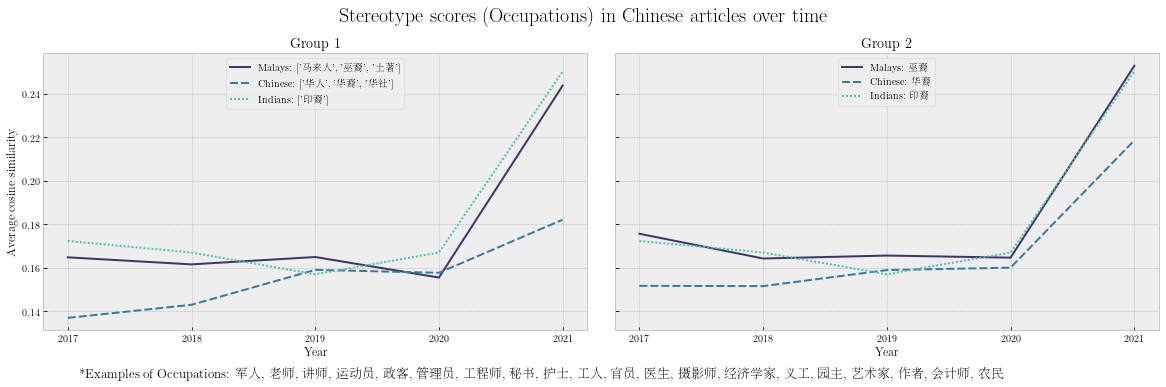

In [23]:
# Occupational stereotypes
# Group 1 - ethnic labels appearing in every year
dist = []

for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, occu_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, occu_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, occu_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(['巫裔'], occu_filtered, embeddings)
    dist_chi = get_average_sim(['华裔'], occu_filtered, embeddings)
    dist_ind = get_average_sim(['印裔'], occu_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format('巫裔'), 
                                    'Chinese: {}'.format('华裔'), 
                                    'Indians: {}'.format('印裔')])


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Occupations) in Chinese articles over time'
annotation = '*Examples of Occupations: ' + ', '.join(occu_filtered[:20]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="mako")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/chi_stereo_occu.eps', format='eps')

Text(0.15, -0.05, '*Examples of Personal Qualities: 保守, 种族主义')

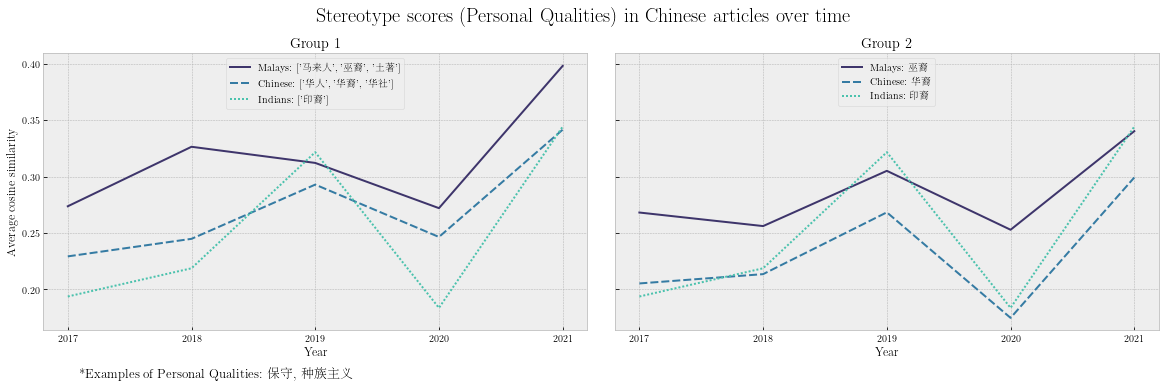

In [171]:
# Stereotypes in previous study: Ibrahim
qualities_ibr = ['保守', '种族主义']

# '懒惰'， '懒散'， '虔诚' , '友善', '友好' (these do not appear every year)

# Group 1 - ethnic labels appearing in every year
dist = []

for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, qualities_ibr, embeddings)
    dist_chi = get_average_sim(chinese_filtered, qualities_ibr, embeddings)
    dist_ind = get_average_sim(indians_filtered, qualities_ibr, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(['巫裔'], qualities_ibr, embeddings)
    dist_chi = get_average_sim(['华裔'], qualities_ibr, embeddings)
    dist_ind = get_average_sim(['印裔'], qualities_ibr, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format('巫裔'), 
                                    'Chinese: {}'.format('华裔'), 
                                    'Indians: {}'.format('印裔')])


fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Personal Qualities) in Chinese articles over time'
annotation = '*Examples of Personal Qualities: ' + ', '.join(qualities_ibr[:20]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="mako")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})

In [78]:
get_close_word('马来人', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,公义,族群,惠顾,不择手段,排挤,社群,理所当然,犹太人,中庸之道,分裂,主义者,外来者,忠于,选票,穆斯林,异教徒,他族,海啸,参政,群起
2018,族群,世俗,叛徒,至上,践踏,华人,牵制,巫裔,社群,特权,同胞,霸权,民族主义,印度人,十二生肖,共产主义,君主,出卖,马来族,先贤
2019,尊严,大团结,而战,巫裔,少数民族,他族,被压迫,族群,犹太人,对非,穆斯林,剿灭,历史事实,化非,社群,种族主义者,印度人,主义者,懒惰,走狗
2020,傀儡,独裁,共产主义,一党,执政者,一心,残暴,沙文主义,尊严,一个多元,主义者,得逞,抗衡,赢家,老调重弹,不满情绪,分明,所作所为,异教徒,族群
2021,个人利益,中庸,大团结,政客,捞取,信仰,讨好,开明,尊严,代表权,出卖,发声,包袱,梦想,前途,魔鬼,论述,担当,对手,罔顾


In [80]:
get_close_word('巫裔', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,印裔,华裔,男子,余岁,少年,年介,男女,一群,离家出走,辍学生,女性,年长者,居多,裔,一名,同胞,已婚,年轻,站台,老妇
2018,印裔,华裔,同胞,马来人,居多,人以,老兵,土着,中年,外地人,男女,特种部队,人则,对非,男同志,娶,或非,生报,面孔,一群
2019,华裔,占多数,印裔,少数民族,马来人,穆斯林,触怒,对非,犹太,更多非,社群,投给,传道,居多,华巫,化非,圣战,年长者,种族主义者,回流
2020,华裔,对友族,印裔,不谙,新面孔,女生,伊班,少年,友族,年仅,名女,占多数,老人家,女性,男性,男,小生,一辈,年轻,同胞
2021,印裔,华裔,女性,家庭主妇,年轻,清廉,女生,选票,一众,一把,听见,佬,唾弃,男性,马来人,不舍,参政,喜爱,污蔑,男生


In [81]:
get_close_word("华裔", models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,印裔,巫裔,同胞,子弟,年轻,友族,未登记,年长者,中学生,常在,年轻人,定居,义工,华人,一群,喝彩,土生土长,居多,多数,服从
2018,巫裔,印裔,华人,生报,同胞,入伍,面孔,名是,居多,子弟,友族,或非,印度人,先贤,数最多,优秀人才,自居,学子,老中青,伊班人
2019,巫裔,印裔,居多,女,矮化,子弟,大票,触怒,屈指可数,男女,同胞,中学生,投票权,心寒,占多数,土生土长,战士,种族主义者,最小,是非
2020,巫裔,印裔,伊班,不谙,新面孔,子弟,小生,嘉雅,女性,对友族,名女,同胞,年轻,占多数,友族,一辈,拉大,多位,两名,子
2021,巫裔,同胞,印裔,子弟,知名人士,行善,家庭主妇,年轻人,喜爱,女性,恭喜发财,女生,各界人士,同志,不舍,清廉,华社,信徒,前辈,选票


In [82]:
get_close_word("印裔", models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,华裔,巫裔,居多,同胞,少数,马来人,裔,印度籍,离家出走,穆斯林,一群,原住民,年轻,一名,女性,青年,社群,强奸案,权益,总人口
2018,巫裔,华裔,一群,男女,一户,未婚,童婚案,小学教师,同胞,居多,中年,学生家长,印度人,锡克族,联络官,缺课,涉毒,位是,名是,穆斯林
2019,华裔,巫裔,社群,触怒,客人,忠诚度,教徒,卡达,投票权,同胞,大票,族群,女,华巫,兴都,有识之士,种族主义者,对非,吉灵人,天主教
2020,华裔,伊班,巫裔,女性,年龄,不谙,同化,小生,同胞,新加坡籍,团员,印度人,男性,裔,居多,族群,土著,锡克,年届,摔角
2021,巫裔,华裔,女性,土著,喜爱,女,男女,妇孺,基督教,一把,女生,参政,家庭主妇,年介,传教士,艺术家,育有,男性,遗孀,妇女
